# **Visualising & Interpreting Wearables Data (ECG & BP measurements)**

In [1]:
# Import necessary libraries
import dash
from dash import html, dcc
from dash.dependencies import Input, Output
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import os 
import matplotlib.pyplot as plt
import neurokit2 as nk
import scipy.signal as signal
import seaborn as sns
import numpy as np
import pywt
from scipy import signal
from scipy.signal import butter, lfilter

In [2]:
#get current working directory

os.getcwd()

'C:\\Users\\georg\\Documents'

In [3]:
# Load the dataset
file_path = 'data_task_interview.csv'  # Update this path as necessary
ecg_bp_data = pd.read_csv(file_path)

In [4]:
#looking at the dataset
ecg_bp_data

,sampleNum,ecg,ibp1,ibp2
0,4100404,1251,63.0,3.0
1,4100405,1270,63.0,3.0
2,4100406,1290,63.0,3.0
3,4100407,1295,63.0,3.0
4,4100408,1296,63.0,3.0
...,...,...,...,...
21995,4122399,1276,83.0,13.0
21996,4122400,1273,82.0,13.0
21997,4122401,1275,81.0,13.0
21998,4122402,1274,80.0,13.0


### **Exploratory Data Analysis & Data Cleaning**

In [5]:
# ---- 1. Data Cleaning ----
# Check for missing values and handle them
print("Missing values in the dataset:", ecg_bp_data.isnull().sum())
ecg_bp_data = ecg_bp_data.dropna()  # Drop rows with missing values or use interpolation
# Alternatively: ecg_data = ecg_data.interpolate(method='linear')

Missing values in the dataset: sampleNum    0
ecg          0
ibp1         0
ibp2         0
dtype: int64


In [6]:
#obtaining summary stats for the dataset#
df = pd.DataFrame(ecg_bp_data)

summary_stats = df.describe()

print(summary_stats)


          sampleNum           ecg          ibp1          ibp2
count  2.200000e+04  22000.000000  22000.000000  22000.000000
mean   4.111404e+06   1309.739636     86.103624     10.531012
std    6.350997e+03     54.345372     70.174246      4.036569
min    4.100404e+06   1215.000000      0.000000      0.000000
25%    4.105904e+06   1276.000000      7.000000      9.000000
50%    4.111404e+06   1290.000000     77.000000     12.000000
75%    4.116903e+06   1315.000000    124.000000     13.000000
max    4.122403e+06   1578.000000    250.000000     25.000000


In [7]:
# Create a new column 'time' that starts at 0 and increases by 5 milliseconds for each row
df['time_msec'] = df.index * 5  # 5 milliseconds per row

In [8]:
# Convert time from milliseconds to seconds (divide by 1000)
df['time_seconds'] = df['time_msec'] / 1000

# Convert time from milliseconds to minutes (divide by 60,000)
df['time_minutes'] = df['time_msec'] / 60000

In [9]:
df

,sampleNum,ecg,ibp1,ibp2,time_msec,time_seconds,time_minutes
0,4100404,1251,63.0,3.0,0,0.000,0.000000
1,4100405,1270,63.0,3.0,5,0.005,0.000083
2,4100406,1290,63.0,3.0,10,0.010,0.000167
3,4100407,1295,63.0,3.0,15,0.015,0.000250
4,4100408,1296,63.0,3.0,20,0.020,0.000333
...,...,...,...,...,...,...,...
21995,4122399,1276,83.0,13.0,109975,109.975,1.832917
21996,4122400,1273,82.0,13.0,109980,109.980,1.833000
21997,4122401,1275,81.0,13.0,109985,109.985,1.833083
21998,4122402,1274,80.0,13.0,109990,109.990,1.833167


In [10]:
# Given time difference between samples (5 milliseconds = 0.005 seconds)
time_diff_seconds = 0.005

# Calculate the sampling rate (in Hz)
sampling_rate_hz = 1 / time_diff_seconds

# Output the sampling rate in Hz
print(f"Sampling rate: {sampling_rate_hz} Hz")

Sampling rate: 200.0 Hz


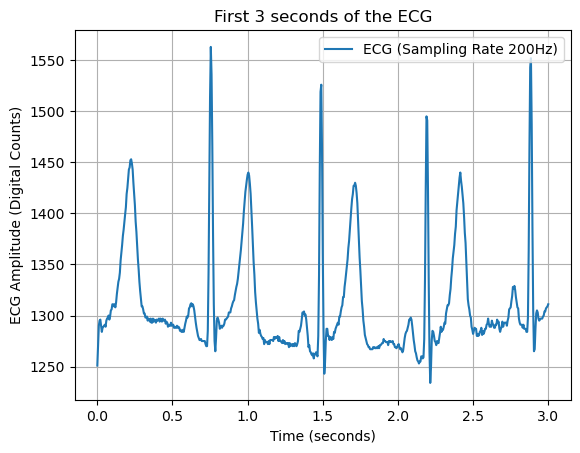

In [11]:
# Filter data for time <= 3 seconds (in this case, your data already fits within 3 seconds)
df_filtered = df[df['time_seconds'] <= 3]

# Plotting the ECG data for the first 3 seconds
plt.plot(df_filtered['time_seconds'], df_filtered['ecg'], label='ECG (Sampling Rate 200Hz)')
plt.title("First 3 seconds of the ECG")
plt.xlabel("Time (seconds)")
plt.ylabel("ECG Amplitude (Digital Counts)")
plt.grid(True)
plt.legend()
plt.show()

In [34]:
# Filter data for time <= 3 seconds (in this case, your data already fits within 3 seconds)
df_filtered = df[df['time_seconds'] <= 10]

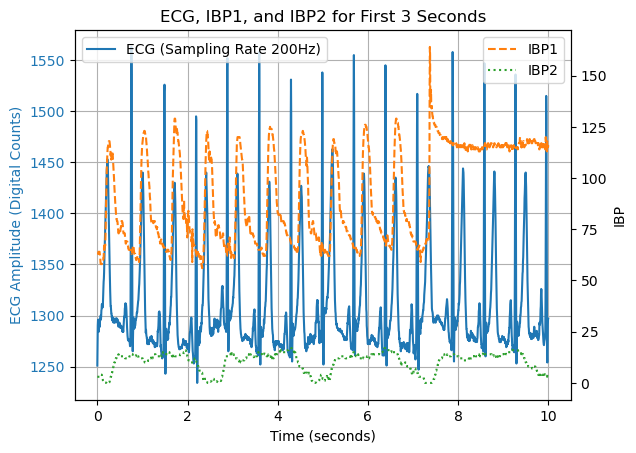

In [35]:
# Create the figure and axis
fig, ax1 = plt.subplots()

# Plot the ECG data on the left y-axis
ax1.plot(df_filtered['time_seconds'], df_filtered['ecg'], label='ECG (Sampling Rate 200Hz)', color='tab:blue')
ax1.set_xlabel("Time (seconds)")
ax1.set_ylabel("ECG Amplitude (Digital Counts)", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a second y-axis for IBP1 and IBP2
ax2 = ax1.twinx()
ax2.plot(df_filtered['time_seconds'], df_filtered['ibp1'], label='IBP1', linestyle='--', color='tab:orange')
ax2.plot(df_filtered['time_seconds'], df_filtered['ibp2'], label='IBP2', linestyle=':', color='tab:green')
ax2.set_ylabel("IBP", color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Adding titles and grid
plt.title("ECG, IBP1, and IBP2 for First 10 Seconds")
ax1.grid(True)

# Add legends for both axes
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show the plot
plt.show()

In [40]:
# Filter data for time <= 3 seconds (in this case, your data already fits within 3 seconds)
df_filtered = df[(df['time_seconds'] >= 0) & (df['time_seconds'] <= 20)]


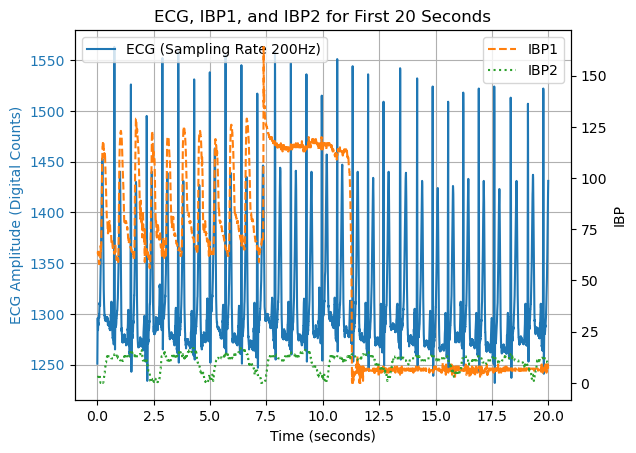

In [42]:
# Create the figure and axis
fig, ax1 = plt.subplots()

# Plot the ECG data on the left y-axis
ax1.plot(df_filtered['time_seconds'], df_filtered['ecg'], label='ECG (Sampling Rate 200Hz)', color='tab:blue')
ax1.set_xlabel("Time (seconds)")
ax1.set_ylabel("ECG Amplitude (Digital Counts)", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a second y-axis for IBP1 and IBP2
ax2 = ax1.twinx()
ax2.plot(df_filtered['time_seconds'], df_filtered['ibp1'], label='IBP1', linestyle='--', color='tab:orange')
ax2.plot(df_filtered['time_seconds'], df_filtered['ibp2'], label='IBP2', linestyle=':', color='tab:green')
ax2.set_ylabel("IBP", color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Adding titles and grid
plt.title("ECG, IBP1, and IBP2 for First 20 Seconds")
ax1.grid(True)

# Add legends for both axes
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show the plot
plt.show()

In [43]:
# Filter data for time <= 3 seconds (in this case, your data already fits within 3 seconds)
df_filtered = df[(df['time_seconds'] >= 20) & (df['time_seconds'] <= 40)]


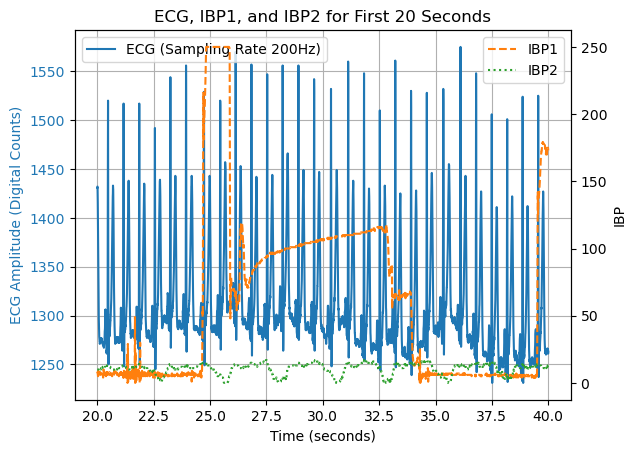

In [44]:
# Create the figure and axis
fig, ax1 = plt.subplots()

# Plot the ECG data on the left y-axis
ax1.plot(df_filtered['time_seconds'], df_filtered['ecg'], label='ECG (Sampling Rate 200Hz)', color='tab:blue')
ax1.set_xlabel("Time (seconds)")
ax1.set_ylabel("ECG Amplitude (Digital Counts)", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a second y-axis for IBP1 and IBP2
ax2 = ax1.twinx()
ax2.plot(df_filtered['time_seconds'], df_filtered['ibp1'], label='IBP1', linestyle='--', color='tab:orange')
ax2.plot(df_filtered['time_seconds'], df_filtered['ibp2'], label='IBP2', linestyle=':', color='tab:green')
ax2.set_ylabel("IBP", color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Adding titles and grid
plt.title("ECG, IBP1, and IBP2 for 20-40 Seconds")
ax1.grid(True)

# Add legends for both axes
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show the plot
plt.show()

In [45]:
# Filter data for time <= 3 seconds (in this case, your data already fits within 3 seconds)
df_filtered = df[(df['time_seconds'] >= 40) & (df['time_seconds'] <= 60)]


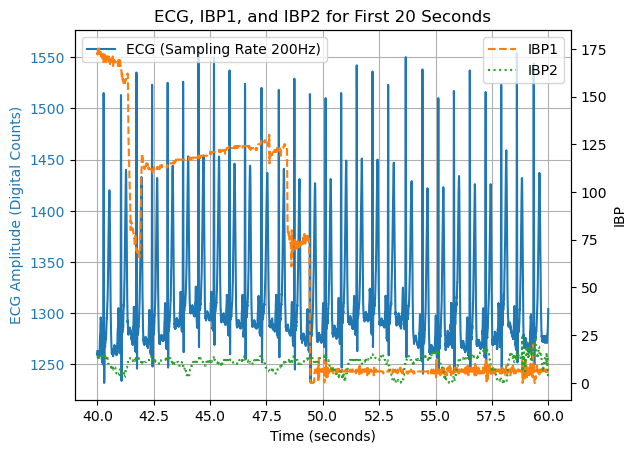

In [46]:
# Create the figure and axis
fig, ax1 = plt.subplots()

# Plot the ECG data on the left y-axis
ax1.plot(df_filtered['time_seconds'], df_filtered['ecg'], label='ECG (Sampling Rate 200Hz)', color='tab:blue')
ax1.set_xlabel("Time (seconds)")
ax1.set_ylabel("ECG Amplitude (Digital Counts)", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a second y-axis for IBP1 and IBP2
ax2 = ax1.twinx()
ax2.plot(df_filtered['time_seconds'], df_filtered['ibp1'], label='IBP1', linestyle='--', color='tab:orange')
ax2.plot(df_filtered['time_seconds'], df_filtered['ibp2'], label='IBP2', linestyle=':', color='tab:green')
ax2.set_ylabel("IBP", color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Adding titles and grid
plt.title("ECG, IBP1, and IBP2 for 40-60 Seconds")
ax1.grid(True)

# Add legends for both axes
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show the plot
plt.show()

In [49]:
# Filter data for time <= 3 seconds (in this case, your data already fits within 3 seconds)
df_filtered = df[(df['time_seconds'] >= 60) & (df['time_seconds'] <= 80)]


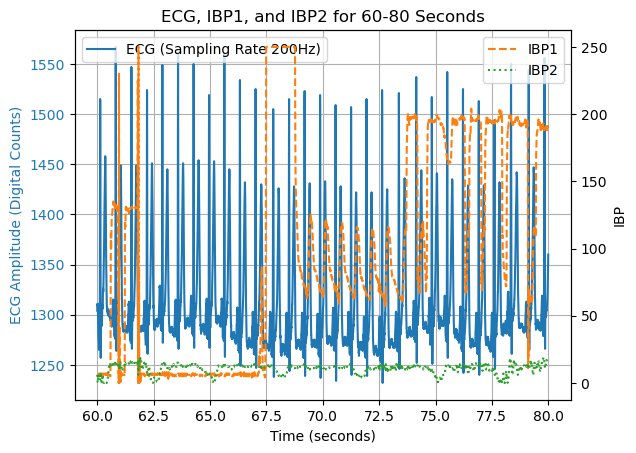

In [50]:
# Create the figure and axis
fig, ax1 = plt.subplots()

# Plot the ECG data on the left y-axis
ax1.plot(df_filtered['time_seconds'], df_filtered['ecg'], label='ECG (Sampling Rate 200Hz)', color='tab:blue')
ax1.set_xlabel("Time (seconds)")
ax1.set_ylabel("ECG Amplitude (Digital Counts)", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a second y-axis for IBP1 and IBP2
ax2 = ax1.twinx()
ax2.plot(df_filtered['time_seconds'], df_filtered['ibp1'], label='IBP1', linestyle='--', color='tab:orange')
ax2.plot(df_filtered['time_seconds'], df_filtered['ibp2'], label='IBP2', linestyle=':', color='tab:green')
ax2.set_ylabel("IBP", color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Adding titles and grid
plt.title("ECG, IBP1, and IBP2 for 60-80 Seconds")
ax1.grid(True)

# Add legends for both axes
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show the plot
plt.show()

In [52]:
# Filter data for time <= 3 seconds (in this case, your data already fits within 3 seconds)
df_filtered = df[(df['time_seconds'] >= 80) & (df['time_seconds'] <= 100)]


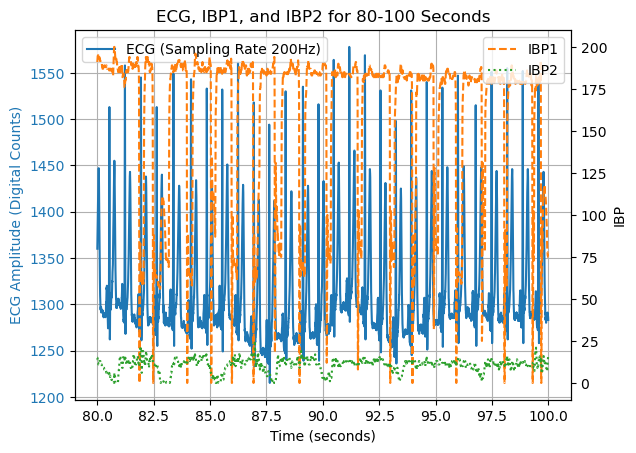

In [53]:
# Create the figure and axis
fig, ax1 = plt.subplots()

# Plot the ECG data on the left y-axis
ax1.plot(df_filtered['time_seconds'], df_filtered['ecg'], label='ECG (Sampling Rate 200Hz)', color='tab:blue')
ax1.set_xlabel("Time (seconds)")
ax1.set_ylabel("ECG Amplitude (Digital Counts)", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a second y-axis for IBP1 and IBP2
ax2 = ax1.twinx()
ax2.plot(df_filtered['time_seconds'], df_filtered['ibp1'], label='IBP1', linestyle='--', color='tab:orange')
ax2.plot(df_filtered['time_seconds'], df_filtered['ibp2'], label='IBP2', linestyle=':', color='tab:green')
ax2.set_ylabel("IBP", color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Adding titles and grid
plt.title("ECG, IBP1, and IBP2 for 80-100 Seconds")
ax1.grid(True)

# Add legends for both axes
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show the plot
plt.show()

In [54]:
# Filter data for time <= 3 seconds (in this case, your data already fits within 3 seconds)
df_filtered = df[(df['time_seconds'] >= 100)]


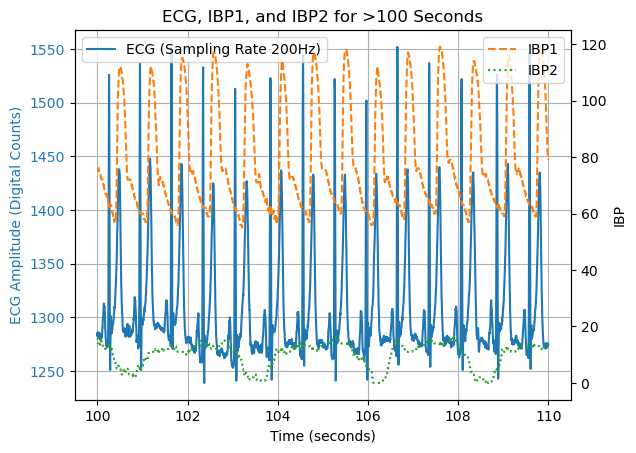

In [55]:
# Create the figure and axis
fig, ax1 = plt.subplots()

# Plot the ECG data on the left y-axis
ax1.plot(df_filtered['time_seconds'], df_filtered['ecg'], label='ECG (Sampling Rate 200Hz)', color='tab:blue')
ax1.set_xlabel("Time (seconds)")
ax1.set_ylabel("ECG Amplitude (Digital Counts)", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a second y-axis for IBP1 and IBP2
ax2 = ax1.twinx()
ax2.plot(df_filtered['time_seconds'], df_filtered['ibp1'], label='IBP1', linestyle='--', color='tab:orange')
ax2.plot(df_filtered['time_seconds'], df_filtered['ibp2'], label='IBP2', linestyle=':', color='tab:green')
ax2.set_ylabel("IBP", color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Adding titles and grid
plt.title("ECG, IBP1, and IBP2 for >100 Seconds")
ax1.grid(True)

# Add legends for both axes
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show the plot
plt.show()

In [ ]:

# Plotting the ECG data for all 1.83 minutes
plt.plot(df['time_minutes'], df['ecg'], label='ECG (Sampling Rate 200Hz)')
plt.title("1.83 Minutes of ECG data")
plt.xlabel("Time (minutes)")
plt.ylabel("ECG Amplitude (Digital Counts)")
plt.grid(True)
plt.legend()
plt.show()

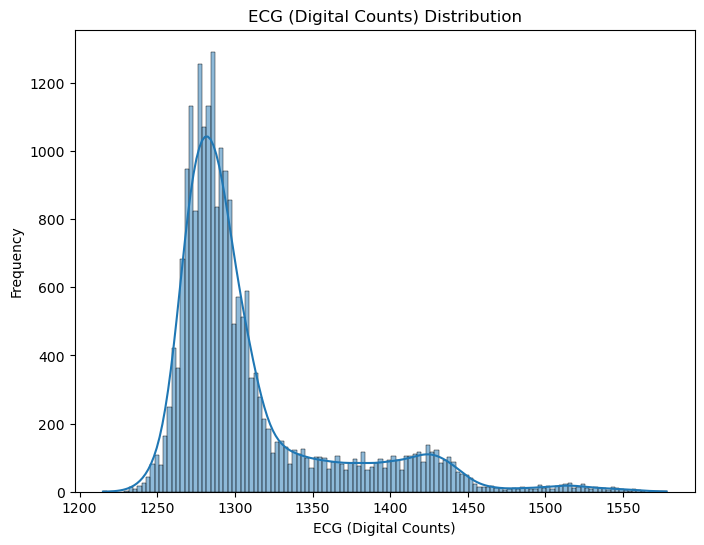

In [13]:
plt.figure(figsize=(8, 6))
sns.histplot(data=ecg_bp_data, x='ecg', kde=True)
plt.title('ECG (Digital Counts) Distribution')
plt.xlabel('ECG (Digital Counts)')
plt.ylabel('Frequency')
plt.show()

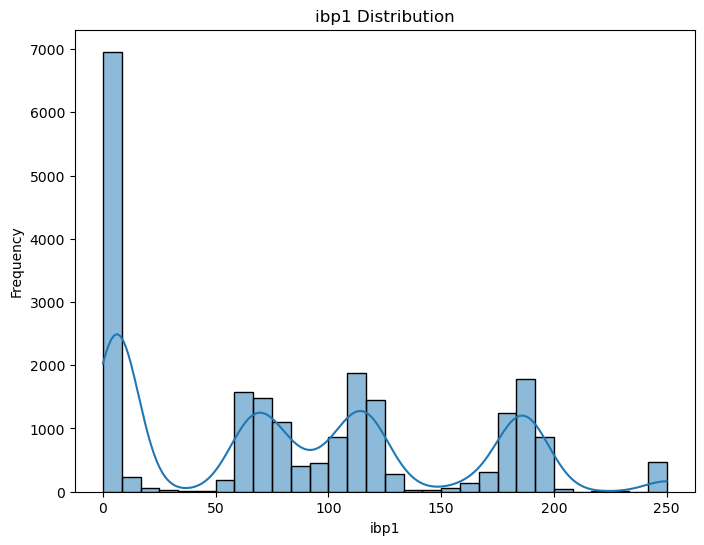

In [21]:
plt.figure(figsize=(8, 6))
sns.histplot(data=ecg_bp_data, x='ibp1', kde=True)
plt.title('ibp1 Distribution')
plt.xlabel('ibp1')
plt.ylabel('Frequency')
plt.show()

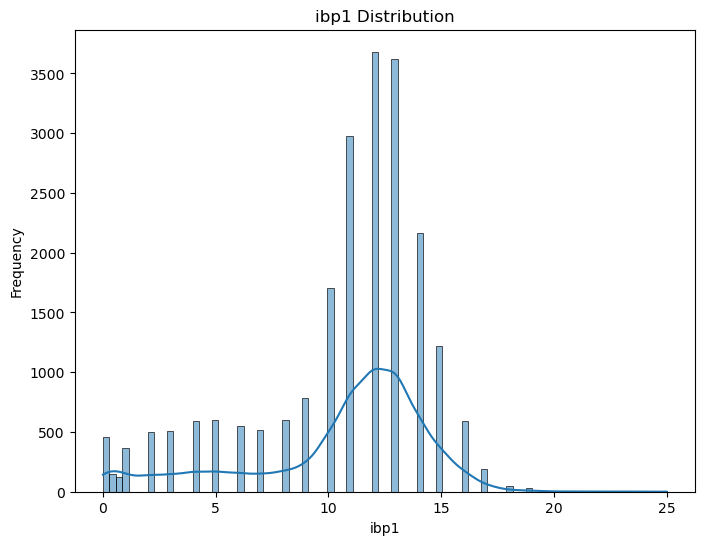

In [22]:
plt.figure(figsize=(8, 6))
sns.histplot(data=ecg_bp_data, x='ibp2', kde=True)
plt.title('ibp1 Distribution')
plt.xlabel('ibp1')
plt.ylabel('Frequency')
plt.show()

C:\Users\georg\AppData\Local\Temp\ipykernel_12172\3120163986.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x='BP_Type', y='ecg', data=melted_data, jitter=True, palette='viridis')


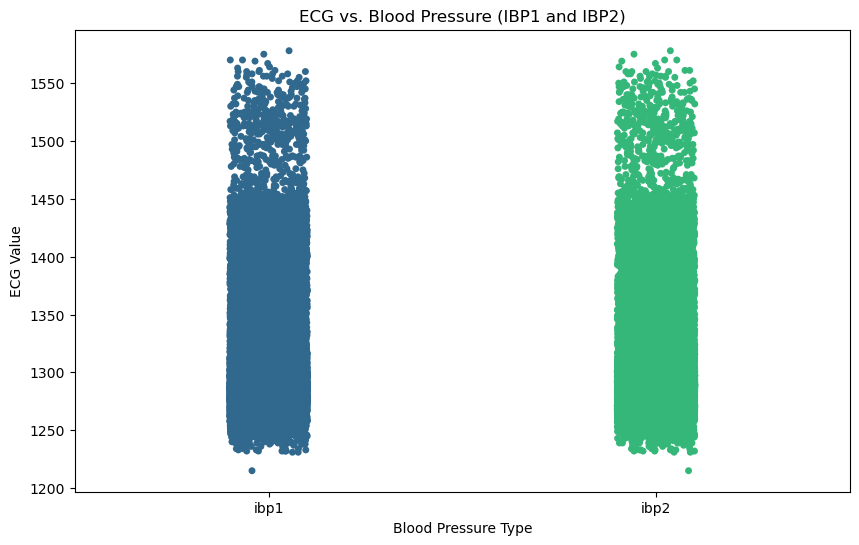

In [14]:
# Melt the DataFrame to compare ECG against IBP1 and IBP2
melted_data = ecg_bp_data.melt(id_vars=['sampleNum', 'ecg'], 
                               value_vars=['ibp1', 'ibp2'], 
                               var_name='BP_Type', 
                               value_name='BP_Value')

# Plot ECG against IBP1 and IBP2 using a strip plot
plt.figure(figsize=(10, 6))
sns.stripplot(x='BP_Type', y='ecg', data=melted_data, jitter=True, palette='viridis')

# Customizing the plot
plt.title('ECG vs. Blood Pressure (IBP1 and IBP2)')
plt.xlabel('Blood Pressure Type')
plt.ylabel('ECG Value')
plt.show()

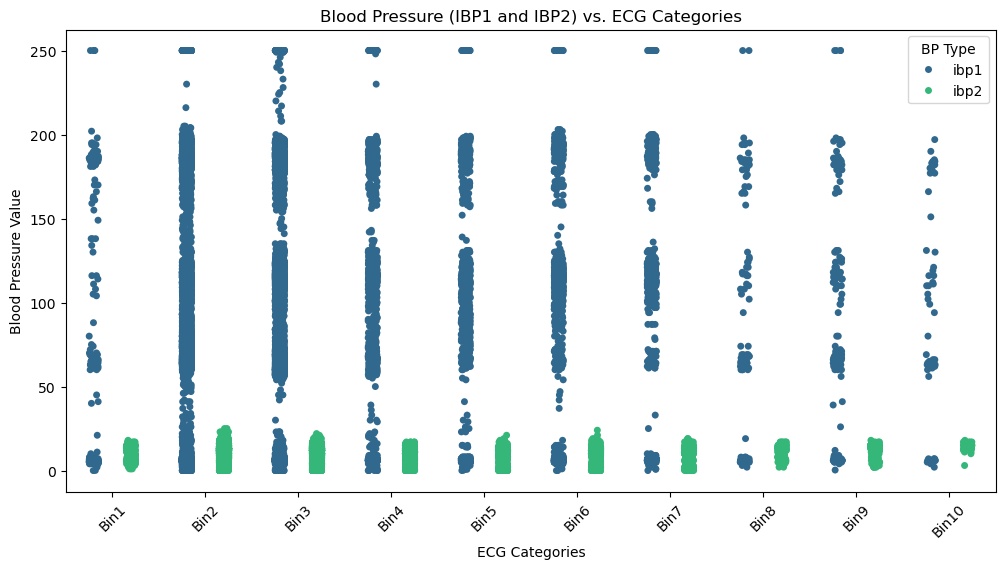

In [15]:
# Bin ECG values into categories
ecg_bp_data['ECG_Category'] = pd.cut(ecg_bp_data['ecg'], 
                                     bins=10,  # Adjust the number of bins as needed
                                     labels=[f'Bin{i+1}' for i in range(10)])  # Name the bins

# Melt the DataFrame to compare IBP1 and IBP2
melted_data = ecg_bp_data.melt(id_vars=['sampleNum', 'ECG_Category'], 
                               value_vars=['ibp1', 'ibp2'], 
                               var_name='BP_Type', 
                               value_name='BP_Value')

# Plot IBP1 and IBP2 values against ECG categories
plt.figure(figsize=(12, 6))
sns.stripplot(x='ECG_Category', y='BP_Value', hue='BP_Type', data=melted_data,
              jitter=True, palette='viridis', dodge=True)

# Customizing the plot
plt.title('Blood Pressure (IBP1 and IBP2) vs. ECG Categories')
plt.xlabel('ECG Categories')
plt.ylabel('Blood Pressure Value')
plt.xticks(rotation=45)  # Rotate for better visibility
plt.legend(title='BP Type')
plt.show()


#### **Denoising**

**Median filter** - Replacing each data point with the median value of the surrounding data points, removing outliers or noise.

In [16]:
# Select only the 'sampleNum' and 'ecg' columns
ecg_data = ecg_bp_data[['ecg']]

# Display the first few rows of the slimmed DataFrame
print(ecg_data.head())

    ecg
0  1251
1  1270
2  1290
3  1295
4  1296


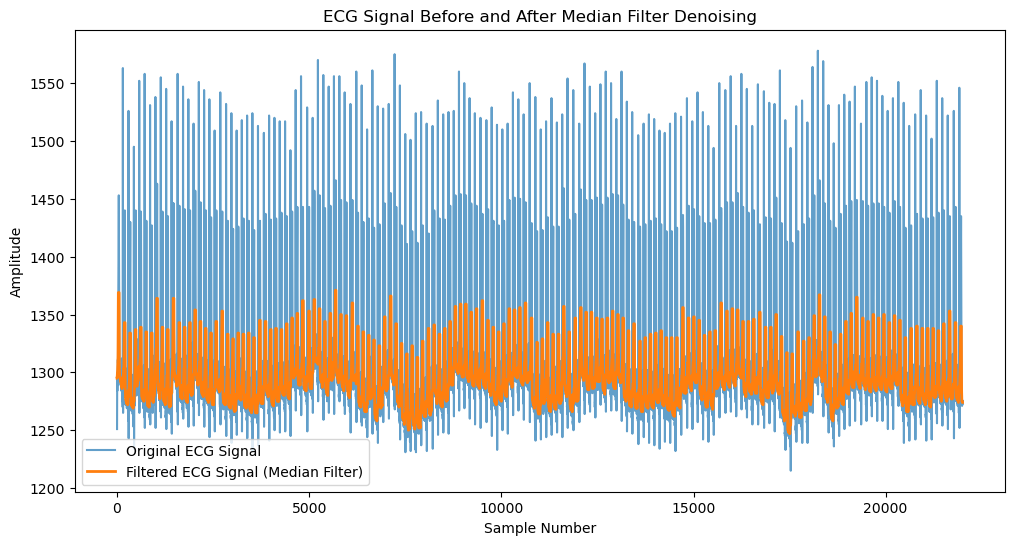

In [17]:
# Median filter function
def median_filter(data, window_size):
    filtered_data = np.zeros(len(data))
    for i in range(len(data)):
        start = max(0, i - window_size // 2)
        end = min(len(data), i + window_size // 2 + 1)
        window = data[start:end]
        filtered_data[i] = np.median(window)
    return filtered_data


# Apply median filter with window size 41
window_size = 41  # Approximately 200 ms at 200 Hz sampling rate
filtered_signal = median_filter(ecg_data, window_size)


# Plot original and filtered signals
plt.figure(figsize=(12, 6))
plt.plot(ecg_data, label='Original ECG Signal', alpha=0.7)
plt.plot(filtered_signal, label='Filtered ECG Signal (Median Filter)', linewidth=2)
plt.title('ECG Signal Before and After Median Filter Denoising')
plt.xlabel('Sample Number')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

In [24]:
filtered_signal

array([1295., 1295., 1295., ..., 1274., 1274., 1274.])

In [ ]:


# Plotting the ECG data for the first 3 seconds
plt.plot(filtered_signal['time_seconds'], df_filtered['ecg'], label='ECG (Sampling Rate 200Hz)')
plt.title("First 3 seconds of the ECG")
plt.xlabel("Time (seconds)")
plt.ylabel("ECG Amplitude (Digital Counts)")
plt.grid(True)
plt.legend()
plt.show()

**Wavelet filter** - Uses wavelet analysis to separate the ECG signal into different frequency components, allowing for selective removal of specific frequency bands that contain noise.

C:\Users\georg\anaconda3\Lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 1 is too high: all coefficients will experience boundary effects.
  warnings.warn(


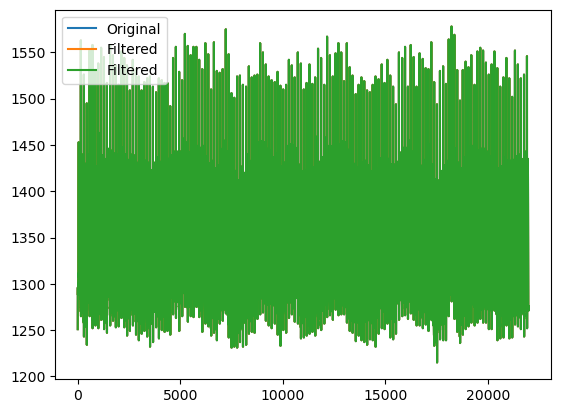

In [18]:

# Define wavelet and level of decomposition
wavelet = 'db4'
level = 1
# Perform wavelet decomposition
coeffs = pywt.wavedec(ecg_data, wavelet, level=level)
# Define threshold for filtering
threshold = 0.1 * np.max(coeffs[-1])
# Perform wavelet thresholding
coeffs_filtered = [pywt.threshold(c, threshold, mode='soft') for c in coeffs]
# Reconstruct filtered signal
ecg_filtered = pywt.waverec(coeffs_filtered, wavelet)
# Plot original and filtered signals
plt.plot(ecg_data, label='Original')
plt.plot(ecg_filtered, label='Filtered')
plt.legend()
plt.show()

**Butterworth filter** - Uses a low-pass filter to remove high-frequency noise from the ECG signal.

In [19]:
ecg_data

,ecg
0,1251
1,1270
2,1290
3,1295
4,1296
...,...
21995,1276
21996,1273
21997,1275
21998,1274


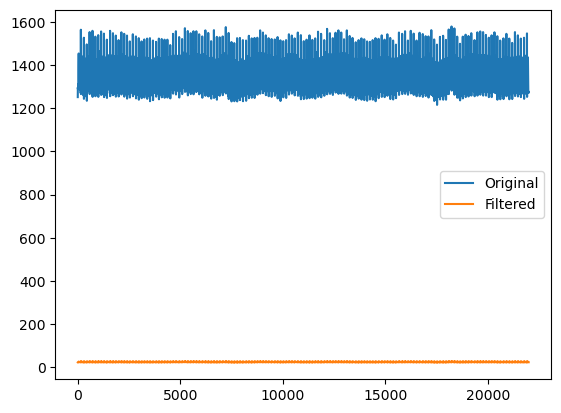

In [20]:
# Cutoff frequency (in Hz)
cutoff = 30
# Order of the filter
order = 4
# Sampling frequency of the ECG signal (in Hz)
fs = 200
# Low-pass filter
b, a = butter(order, cutoff/(fs/2), btype='low')

# Apply the filter
ecg_filtered = lfilter(b, a, ecg_data)

# Plot the original signal
plt.plot(ecg_data, label='Original')
plt.plot(ecg_filtered, label='Filtered')
plt.legend()
plt.show()

## Handling IBP1 & IBP2 

IBP1 might indeed be systolic pressure, which typically ranges from 90 to 120 mmHg for a healthy individual, so its mean of 86, with a max of 250 and min of 0, makes sense but requires smoothing (e.g., a rolling average) to eliminate noise.

IBP2, on the other hand, could represent a pulse pressure (the difference between systolic and diastolic pressures) or some other derived metric that has a much smaller range.

In [57]:
# Select only the 'sampleNum' and 'ecg' columns
ibp1_data = ecg_bp_data[['ibp1']]

# Display the first few rows of the slimmed DataFrame
print(ibp1_data.head())

   ibp1
0  63.0
1  63.0
2  63.0
3  63.0
4  63.0


In [87]:
# Apply rolling average (smoothing) to IBP1
ibp1_smoothed = ibp1_data.rolling(window=1000).mean()  # window size can be adjusted



In [88]:
ibp1_smoothed

,ibp1
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
21995,78.909
21996,78.915
21997,78.920
21998,78.924


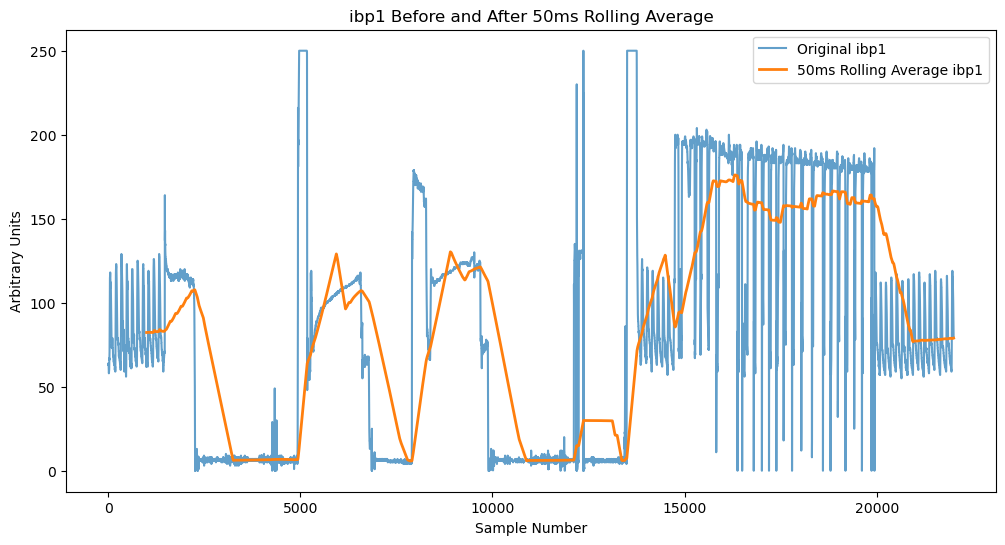

In [89]:
# Plot original and filtered signals
plt.figure(figsize=(12, 6))
plt.plot(ibp1_data, label='Original ibp1', alpha=0.7)
plt.plot(ibp1_smoothed, label='50ms Rolling Average ibp1', linewidth=2)
plt.title('ibp1 Before and After 50ms Rolling Average')
plt.xlabel('Sample Number')
plt.ylabel('Arbitrary Units')
plt.legend()
plt.show()

In [90]:
# Select only the 'sampleNum' and 'ecg' columns
ibp2_data = ecg_bp_data[['ibp2']]

# Display the first few rows of the slimmed DataFrame
print(ibp2_data.head())

   ibp2
0   3.0
1   3.0
2   3.0
3   3.0
4   3.0


In [93]:
# Apply rolling average (smoothing) to IBP1
ibp2_smoothed = ibp2_data.rolling(window=2000).mean()  # window size can be adjusted

ibp2_smoothed

,ibp2
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
21995,10.029705
21996,10.029705
21997,10.029205
21998,10.028205


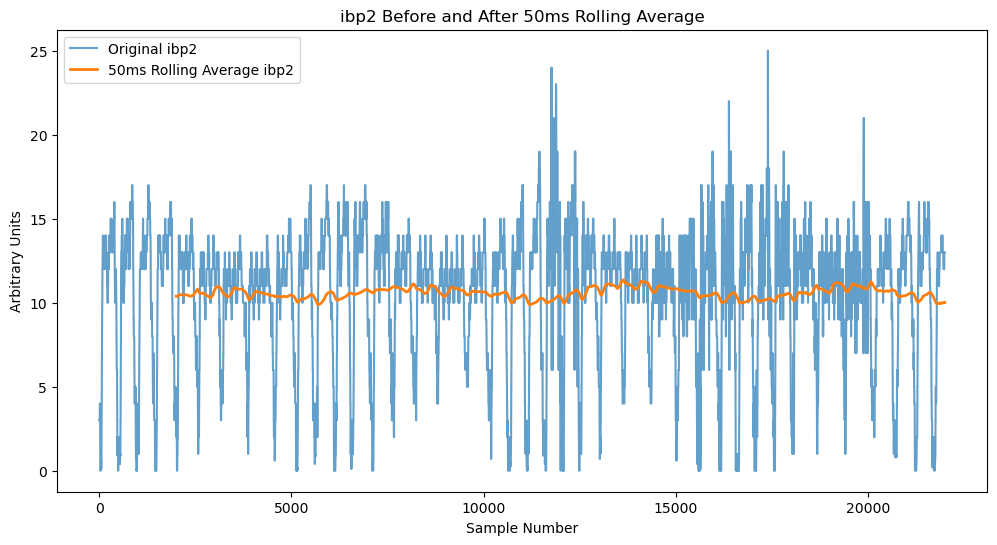

In [94]:
# Plot original and filtered signals
plt.figure(figsize=(12, 6))
plt.plot(ibp2_data, label='Original ibp2', alpha=0.7)
plt.plot(ibp2_smoothed, label='50ms Rolling Average ibp2', linewidth=2)
plt.title('ibp2 Before and After 50ms Rolling Average')
plt.xlabel('Sample Number')
plt.ylabel('Arbitrary Units')
plt.legend()
plt.show()

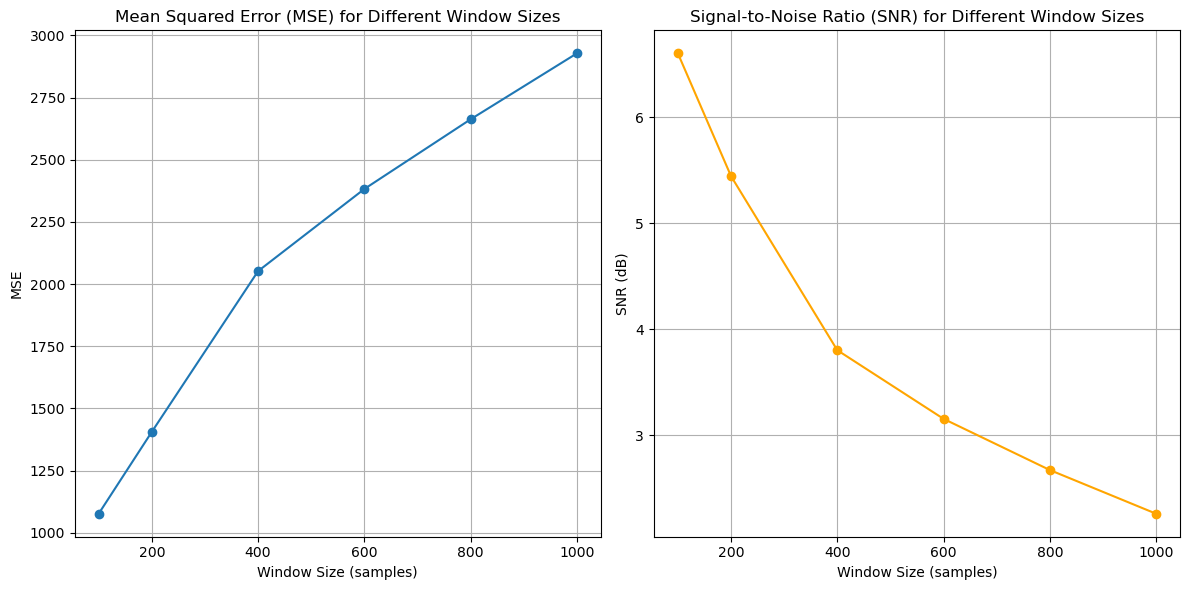

TypeError: unsupported format string passed to Series.__format__

In [99]:
# Function to compute Mean Squared Error (MSE)
def compute_mse(original, filtered):
    return np.mean((original - filtered) ** 2)

# Function to compute Signal-to-Noise Ratio (SNR)
def compute_snr(original, filtered):
    noise = original - filtered
    signal_power = np.var(original)
    noise_power = np.var(noise)
    return 10 * np.log10(signal_power / noise_power)

# Define window sizes to test
window_sizes = [100, 200, 400, 600,800,1000]

mse_values = []
snr_values = []

# Loop through each window size, compute smoothed signal, MSE, and SNR
for window in window_sizes:
    smoothed_signal = ibp1_data.rolling(window=window).mean()
    
    # Compute MSE
    mse = compute_mse(ibp1_data, smoothed_signal)
    mse_values.append(mse)
    
    # Compute SNR
    snr = compute_snr(ibp1_data, smoothed_signal)
    snr_values.append(snr)

# Plot MSE for different window sizes
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(window_sizes, mse_values, marker='o')
plt.title('Mean Squared Error (MSE) for Different Window Sizes')
plt.xlabel('Window Size (samples)')
plt.ylabel('MSE')
plt.grid(True)

# Plot SNR for different window sizes
plt.subplot(1, 2, 2)
plt.plot(window_sizes, snr_values, marker='o', color='orange')
plt.title('Signal-to-Noise Ratio (SNR) for Different Window Sizes')
plt.xlabel('Window Size (samples)')
plt.ylabel('SNR (dB)')
plt.grid(True)

plt.tight_layout()
plt.show()

# Output the results
for window, mse, snr in zip(window_sizes, mse_values, snr_values):
    print(f"Window Size: {window}, MSE: {mse:.4f}, SNR: {snr:.2f} dB")

C:\Users\georg\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


ValueError: x and y must have same first dimension, but have shapes (6,) and (18,)

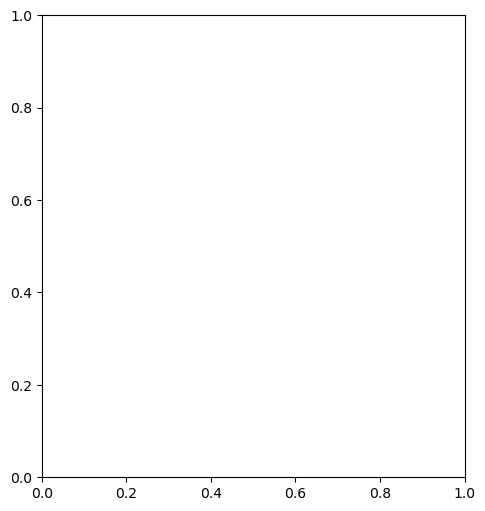

In [101]:
# Loop through each window size, compute smoothed signal, MSE, and SNR
for window in window_sizes:
    smoothed_signal = ibp2_data.rolling(window=window).mean()
    
    # Compute MSE
    mse = compute_mse(ibp2_data, smoothed_signal)
    mse_values.append(mse)
    
    # Compute SNR
    snr = compute_snr(ibp2_data, smoothed_signal)
    snr_values.append(snr)

# Plot MSE for different window sizes
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(window_sizes, mse_values, marker='o')
plt.title('Mean Squared Error (MSE) for Different Window Sizes')
plt.xlabel('Window Size (samples)')
plt.ylabel('MSE')
plt.grid(True)

# Plot SNR for different window sizes
plt.subplot(1, 2, 2)
plt.plot(window_sizes, snr_values, marker='o', color='orange')
plt.title('Signal-to-Noise Ratio (SNR) for Different Window Sizes')
plt.xlabel('Window Size (samples)')
plt.ylabel('SNR (dB)')
plt.grid(True)

plt.tight_layout()
plt.show()

# Output the results
for window, mse, snr in zip(window_sizes, mse_values, snr_values):
    print(f"Window Size: {window}, MSE: {mse:.4f}, SNR: {snr:.2f} dB")